In [1]:
import random
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import xgboost as xgb
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC

from sklearn.metrics import accuracy_score, roc_auc_score
from imblearn.over_sampling import SMOTE
from sklearn.utils import shuffle
from sklearn.utils.random import sample_without_replacement

## Read the dataset

In [2]:
df_delay = pd.read_csv('combined_data_mkt.csv')

In [3]:
df_delay

,Year,Month,DayOfWeek,Operating_Airline,Tail_Number,Origin,OriginState,Dest,DestState,DepDelayMinutes,...,TaxiIn,ArrDel15,ArrDelayMinutes,ArrTimeBlk,Distance,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,DistanceGroup
0,2018,10,1,9E,N8694A,ATL,GA,EWN,NC,0.0,...,3.0,0.0,2.0,2100-2159,433.0,NaN,NaN,NaN,NaN,2.0
1,2018,10,2,9E,N834AY,ATL,GA,EWN,NC,64.0,...,3.0,1.0,69.0,2100-2159,433.0,23.0,0.0,5.0,0.0,2.0
2,2018,10,3,9E,N8688C,ATL,GA,EWN,NC,0.0,...,6.0,0.0,6.0,2100-2159,433.0,NaN,NaN,NaN,NaN,2.0
3,2018,10,4,9E,N833AY,ATL,GA,EWN,NC,2.0,...,3.0,0.0,13.0,2100-2159,433.0,NaN,NaN,NaN,NaN,2.0
4,2018,10,5,9E,N980EV,ATL,GA,EWN,NC,0.0,...,2.0,0.0,0.0,2100-2159,433.0,NaN,NaN,NaN,NaN,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7886168,2023,4,3,OH,N562NN,BTR,LA,CLT,NC,36.0,...,17.0,1.0,30.0,1000-1059,675.0,30.0,0.0,0.0,0.0,3.0
7886169,2023,4,4,OH,N597NN,BTR,LA,CLT,NC,0.0,...,14.0,0.0,8.0,1000-1059,675.0,NaN,NaN,NaN,NaN,3.0
7886170,2023,4,5,OH,N550NN,BTR,LA,CLT,NC,0.0,...,16.0,0.0,0.0,1000-1059,675.0,NaN,NaN,NaN,NaN,3.0
7886171,2023,4,6,OH,N588NN,BTR,LA,CLT,NC,0.0,...,22.0,0.0,0.0,1000-1059,675.0,NaN,NaN,NaN,NaN,3.0


In [4]:
df_delay['DistanceGroup'] = df_delay['DistanceGroup'].astype(str)

In [5]:
month_mapping = {
    1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun',
    7: 'Jul', 8: 'Aug', 9: 'Sept', 10: 'Oct', 11: 'Nov', 12: 'Dec'
}

In [6]:
day_mapping = {
    1: 'Mon', 2: 'Tue', 3: 'Wed', 4: 'Thu', 5: 'Fri', 6: 'Sat', 7: 'Sun'
}

In [7]:
# Apply mappings to Month and DayOfWeek columns
df_delay['Month'] = df_delay['Month'].map(month_mapping)
df_delay['DayOfWeek'] = df_delay['DayOfWeek'].map(day_mapping)

In [8]:
df_delay.drop(columns = ["CarrierDelay", "DistanceGroup", "WeatherDelay", "DepDel15","NASDelay", 
                         "WheelsOn", "SecurityDelay", "ArrDelayMinutes", "OriginState", "DestState", 
                         "Tail_Number", "OriginState", "Origin", "Dest", "Year"], inplace=True)

**Clean the dataset**

In [9]:
null_values = df_delay.isnull().sum()
null_values

Month                     0
DayOfWeek                 0
Operating_Airline         0
DepDelayMinutes      175083
DepTimeBlk                0
TaxiOut              179313
WheelsOff            179313
TaxiIn               183844
ArrDel15             199673
ArrTimeBlk                0
Distance                  0
dtype: int64

In [10]:
mean_dep_delay = df_delay['DepDelayMinutes'].mean()
median_taxi_out = df_delay['TaxiOut'].median()
median_taxi_in = df_delay['TaxiIn'].median()
median_wheels_off = df_delay['WheelsOff'].median()

In [11]:
df_input = df_delay.fillna({'DepDelayMinutes': mean_dep_delay, 'TaxiOut': median_taxi_out, 'TaxiIn': median_taxi_in, 'WheelsOff': median_wheels_off})

In [12]:
df = df_input.dropna(subset=['ArrDel15'])

In [13]:
df.reset_index(drop=True, inplace=True)

In [14]:
df

,Month,DayOfWeek,Operating_Airline,DepDelayMinutes,DepTimeBlk,TaxiOut,WheelsOff,TaxiIn,ArrDel15,ArrTimeBlk,Distance
0,Oct,Mon,9E,0.0,1900-1959,30.0,2023.0,3.0,0.0,2100-2159,433.0
1,Oct,Tue,9E,64.0,1900-1959,30.0,2131.0,3.0,1.0,2100-2159,433.0
2,Oct,Wed,9E,0.0,1900-1959,28.0,2022.0,6.0,0.0,2100-2159,433.0
3,Oct,Thu,9E,2.0,1900-1959,28.0,2027.0,3.0,0.0,2100-2159,433.0
4,Oct,Fri,9E,0.0,1900-1959,22.0,2016.0,2.0,0.0,2100-2159,433.0
...,...,...,...,...,...,...,...,...,...,...,...
7686495,Apr,Wed,OH,36.0,0700-0759,10.0,746.0,17.0,1.0,1000-1059,675.0
7686496,Apr,Thu,OH,0.0,0700-0759,20.0,710.0,14.0,0.0,1000-1059,675.0
7686497,Apr,Fri,OH,0.0,0700-0759,12.0,659.0,16.0,0.0,1000-1059,675.0
7686498,Apr,Sat,OH,0.0,0700-0759,11.0,702.0,22.0,0.0,1000-1059,675.0


## Prepare for modeling training

In [15]:
Y = df["ArrDel15"]
df.drop(columns=["ArrDel15"], inplace=True)

c:\python37\lib\site-packages\pandas\core\frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [16]:
X = df
non_number_cols = [k for k in X.keys() if str(X[k].dtype) not in ["int64", "float64"]]

number_cols = list(set(X.keys()) - set(non_number_cols))
X_numeric = X[number_cols]
X_non_numeric = pd.get_dummies(X[non_number_cols], drop_first=False)

In [17]:
std_scaler = StandardScaler(copy=False)
X_numeric_array = std_scaler.fit_transform(X_numeric)
X_numeric = pd.DataFrame(X_numeric_array, columns=X_numeric.keys())

In [18]:
X = pd.concat([X_numeric, X_non_numeric], axis=1)

In [19]:
#split dataset into train and test sets
idxs = list(range(0, len(X)))

random_seed = 42
test_size = 0.2

train_idxs, test_idxs = train_test_split(idxs, test_size=0.2, random_state=42)

In [20]:
X_train = X.iloc[train_idxs]
X_test = X.iloc[test_idxs]

Y_train = Y.iloc[train_idxs]
Y_test = Y.iloc[test_idxs]

In [21]:
Y_train_percentage = (Y_train.value_counts() / len(Y_train)) * 100
Y_train_percentage

0.0    80.101916
1.0    19.898084
Name: ArrDel15, dtype: float64

In [22]:
Y_test_percentage = (Y_test.value_counts() / len(Y_test)) * 100
Y_test_percentage

0.0    80.13966
1.0    19.86034
Name: ArrDel15, dtype: float64

**Over Resampling Minority Class**

In [23]:
X_train_1, Y_train_1 = X_train[Y_train == 1], Y_train[Y_train == 1]
X_train_0, Y_train_0 = X_train[Y_train == 0], Y_train[Y_train == 0]

In [24]:
#over sample minority class with a specific ratio
ratio_scaler = 4
oversample_ratio = 3
ratio = (ratio_scaler * len(X_train_1))/len(X_train_0)
ratio = 0.999 if ratio > 1.0 else ratio

In [25]:
X_train_0, _, Y_train_0, _ = train_test_split(X_train_0, Y_train_0, train_size=ratio)

In [26]:
X_train = pd.concat([X_train_0] + [X_train_1] * oversample_ratio)
Y_train = pd.concat([Y_train_0] + [Y_train_1] * oversample_ratio)

In [27]:
X_train, Y_train = shuffle(X_train, Y_train, random_state=random_seed)

In [28]:
Y_train_percentage = (Y_train.value_counts() / len(Y_train)) * 100
Y_train_percentage

0.0    57.142857
1.0    42.857143
Name: ArrDel15, dtype: float64

## Data Modeling

In [44]:
from sklearn.metrics import accuracy_score, precision_score, recall_score

**1. Decision Tree**

In [29]:
#DecisionTreeClassifier
clf = DecisionTreeClassifier(random_state=0)
clf.fit(X_train, Y_train)

DecisionTreeClassifier(random_state=0)

In [46]:
y_pred_train_clf = clf.predict(X_train)

accuracy_clf = accuracy_score(Y_train, y_pred_train_clf)
precision_clf = precision_score(Y_train, y_pred_train_clf)
recall_clf = recall_score(Y_train, y_pred_train_clf)

print(f"Accuracy: {accuracy_clf}")
print(f"Precision: {precision_clf}")
print(f"Recall: {recall_clf}")

Accuracy: 0.9999898423948317
Precision: 0.9999762994830018
Recall: 1.0


**2. AdaBoost**

In [30]:
ada = AdaBoostClassifier(n_estimators=20, random_state=random_seed)
ada.fit(X_train, Y_train)

AdaBoostClassifier(n_estimators=20, random_state=42)

In [47]:
y_pred_train_ada = ada.predict(X_train)

accuracy_ada = accuracy_score(Y_train, y_pred_train_ada)
precision_ada = precision_score(Y_train, y_pred_train_ada)
recall_ada = recall_score(Y_train, y_pred_train_ada)

print(f"Accuracy: {accuracy_ada}")
print(f"Precision: {precision_ada}")
print(f"Recall: {recall_ada}")

Accuracy: 0.9196019713226288
Precision: 0.9089904668382847
Recall: 0.9027937033589333


**3. Gradient Boosting**

In [31]:
#Gradient Boosting Classifier
gb = GradientBoostingClassifier(n_estimators=20, max_depth=3, validation_fraction=0.2, n_iter_no_change=5, tol=0.01)
gb.fit(X_train, Y_train)

GradientBoostingClassifier(n_estimators=20, n_iter_no_change=5, tol=0.01,
                           validation_fraction=0.2)

In [50]:
y_pred_train_gb = gb.predict(X_train)

accuracy_gb = accuracy_score(Y_train, y_pred_train_gb)
precision_gb = precision_score(Y_train, y_pred_train_gb)
recall_gb = recall_score(Y_train, y_pred_train_gb)

print(f"Accuracy: {accuracy_gb}")
print(f"Precision: {precision_gb}")
print(f"Recall: {recall_gb}")

Accuracy: 0.920252408315646
Precision: 0.9295448062643197
Recall: 0.8806732414003905


**4. Random forest**

In [32]:
#random forest
rf = RandomForestClassifier(n_estimators=20, random_state=random_seed)
rf.fit(X_train, Y_train)

RandomForestClassifier(n_estimators=20, random_state=42)

In [51]:
y_pred_train_rf = rf.predict(X_train)

accuracy_rf = accuracy_score(Y_train, y_pred_train_rf)
precision_rf = precision_score(Y_train, y_pred_train_rf)
recall_rf = recall_score(Y_train, y_pred_train_rf)

print(f"Accuracy: {accuracy_rf}")
print(f"Precision: {precision_rf}")
print(f"Recall: {recall_rf}")

Accuracy: 0.9998667835919883
Precision: 0.9996892583050552
Recall: 1.0


**Train model evaluation**

## Model Evaluation

In [33]:
from sklearn.metrics import (accuracy_score, recall_score, precision_score, roc_curve, auc, confusion_matrix)

In [34]:
class_0_ratio = 0.78
class_1_ratio = 0.22

num_splits = int(class_0_ratio/class_1_ratio)
split_size = len(Y_test) // num_splits

In [35]:
avg_accuracy_clf = 0
avg_recall_clf = 0
avg_precision_clf = 0

for i in range(num_splits):
    start_idx = i * split_size
    end_idx = (i + 1) * split_size

    # Create a smaller test set by combining class 0 instances with class 1 instances
    smaller_X_test = np.vstack([X_test[start_idx:end_idx], X_test[Y_test == 1]])
    smaller_Y_test = np.hstack([Y_test[start_idx:end_idx], Y_test[Y_test == 1]])

    # Make predictions on the smaller test set
    predictions_clf = clf.predict(smaller_X_test)

    # Calculate accuracy, recall, and precision
    accuracy_clf = accuracy_score(smaller_Y_test, predictions_clf)
    recall_clf = recall_score(smaller_Y_test, predictions_clf)
    precision_clf = precision_score(smaller_Y_test, predictions_clf)

    # Accumulate metrics for averaging
    avg_accuracy_clf += accuracy_clf
    avg_recall_clf += recall_clf
    avg_precision_clf += precision_clf

# Calculate the average metrics over all smaller test sets
avg_accuracy_clf /= num_splits
avg_recall_clf /= num_splits
avg_precision_clf /= num_splits

# Print the average metrics
print("Average Accuracy clf:", avg_accuracy_clf)
print("Average Recall clf:", avg_recall_clf)
print("Average Precision clf:", avg_precision_clf)

c:\python37\lib\site-packages\sklearn\base.py:451: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  "X does not have valid feature names, but"
c:\python37\lib\site-packages\sklearn\base.py:451: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  "X does not have valid feature names, but"
c:\python37\lib\site-packages\sklearn\base.py:451: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  "X does not have valid feature names, but"


Average Accuracy clf: 0.8865401563158569
Average Recall clf: 0.8198339087396613
Average Precision clf: 0.9449611420304077


In [36]:
avg_accuracy_ada = 0
avg_recall_ada = 0
avg_precision_ada = 0

for i in range(num_splits):
    start_idx = i * split_size
    end_idx = (i + 1) * split_size

    # Create a smaller test set by combining class 0 instances with class 1 instances
    smaller_X_test = np.vstack([X_test[start_idx:end_idx], X_test[Y_test == 1]])
    smaller_Y_test = np.hstack([Y_test[start_idx:end_idx], Y_test[Y_test == 1]])

    # Make predictions on the smaller test set
    predictions_ada = ada.predict(smaller_X_test)

    # Calculate accuracy, recall, and precision
    accuracy_ada = accuracy_score(smaller_Y_test, predictions_ada)
    recall_ada = recall_score(smaller_Y_test, predictions_ada)
    precision_ada = precision_score(smaller_Y_test, predictions_ada)

    # Accumulate metrics for averaging
    avg_accuracy_ada += accuracy_ada
    avg_recall_ada += recall_ada
    avg_precision_ada += precision_ada

# Calculate the average metrics over all smaller test sets
avg_accuracy_ada /= num_splits
avg_recall_ada /= num_splits
avg_precision_ada /= num_splits

# Print the average metrics
print("Average Accuracy ada:", avg_accuracy_ada)
print("Average Recall ada:", avg_recall_ada)
print("Average Precision ada:", avg_precision_ada)

c:\python37\lib\site-packages\sklearn\base.py:451: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  "X does not have valid feature names, but"
c:\python37\lib\site-packages\sklearn\base.py:451: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  "X does not have valid feature names, but"
c:\python37\lib\site-packages\sklearn\base.py:451: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  "X does not have valid feature names, but"


Average Accuracy ada: 0.9175530462189156
Average Recall ada: 0.9027423803925952
Average Precision ada: 0.9296047572479393


In [37]:
avg_accuracy_gb = 0
avg_recall_gb = 0
avg_precision_gb = 0

for i in range(num_splits):
    start_idx = i * split_size
    end_idx = (i + 1) * split_size

    # Create a smaller test set by combining class 0 instances with class 1 instances
    smaller_X_test = np.vstack([X_test[start_idx:end_idx], X_test[Y_test == 1]])
    smaller_Y_test = np.hstack([Y_test[start_idx:end_idx], Y_test[Y_test == 1]])

    # Make predictions on the smaller test set
    predictions_gb = gb.predict(smaller_X_test)

    # Calculate accuracy, recall, and precision
    accuracy_gb = accuracy_score(smaller_Y_test, predictions_gb)
    recall_gb = recall_score(smaller_Y_test, predictions_gb)
    precision_gb = precision_score(smaller_Y_test, predictions_gb)

    # Accumulate metrics for averaging
    avg_accuracy_gb += accuracy_gb
    avg_recall_gb += recall_gb
    avg_precision_gb += precision_gb

# Calculate the average metrics over all smaller test sets
avg_accuracy_gb /= num_splits
avg_recall_gb /= num_splits
avg_precision_gb /= num_splits

# Print the average metrics
print("Average Accuracy gb:", avg_accuracy_gb)
print("Average Recall gb:", avg_recall_gb)
print("Average Precision gb:", avg_precision_gb)

c:\python37\lib\site-packages\sklearn\base.py:451: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  "X does not have valid feature names, but"
c:\python37\lib\site-packages\sklearn\base.py:451: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  "X does not have valid feature names, but"
c:\python37\lib\site-packages\sklearn\base.py:451: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  "X does not have valid feature names, but"


Average Accuracy gb: 0.9154248385195403
Average Recall gb: 0.8805618513777599
Average Precision gb: 0.9458058873570891


In [38]:
avg_accuracy_rf = 0
avg_recall_rf = 0
avg_precision_rf = 0

for i in range(num_splits):
    start_idx = i * split_size
    end_idx = (i + 1) * split_size

    # Create a smaller test set by combining class 0 instances with class 1 instances
    smaller_X_test = np.vstack([X_test[start_idx:end_idx], X_test[Y_test == 1]])
    smaller_Y_test = np.hstack([Y_test[start_idx:end_idx], Y_test[Y_test == 1]])

    # Make predictions on the smaller test set
    predictions_rf = rf.predict(smaller_X_test)

    # Calculate accuracy, recall, and precision
    accuracy_rf = accuracy_score(smaller_Y_test, predictions_rf)
    recall_rf = recall_score(smaller_Y_test, predictions_rf)
    precision_rf = precision_score(smaller_Y_test, predictions_rf)

    # Accumulate metrics for averaging
    avg_accuracy_rf += accuracy_rf
    avg_recall_rf += recall_rf
    avg_precision_rf += precision_rf

# Calculate the average metrics over all smaller test sets
avg_accuracy_rf /= num_splits
avg_recall_rf /= num_splits
avg_precision_rf /= num_splits

# Print the average metrics
print("Average Accuracy rf:", avg_accuracy_rf)
print("Average Recall rf:", avg_recall_rf)
print("Average Precision rf:", avg_precision_rf)

c:\python37\lib\site-packages\sklearn\base.py:451: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  "X does not have valid feature names, but"
c:\python37\lib\site-packages\sklearn\base.py:451: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  "X does not have valid feature names, but"
c:\python37\lib\site-packages\sklearn\base.py:451: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  "X does not have valid feature names, but"


Average Accuracy rf: 0.9131759739576837
Average Recall rf: 0.8530229163336674
Average Precision rf: 0.968841105100152


In [39]:
models = ['clf', 'ada', 'gb', 'rf']
avg_accuracies = [avg_accuracy_clf, avg_accuracy_ada, avg_accuracy_gb, avg_accuracy_rf]
predictions = [predictions_clf, predictions_ada, predictions_gb, predictions_rf]

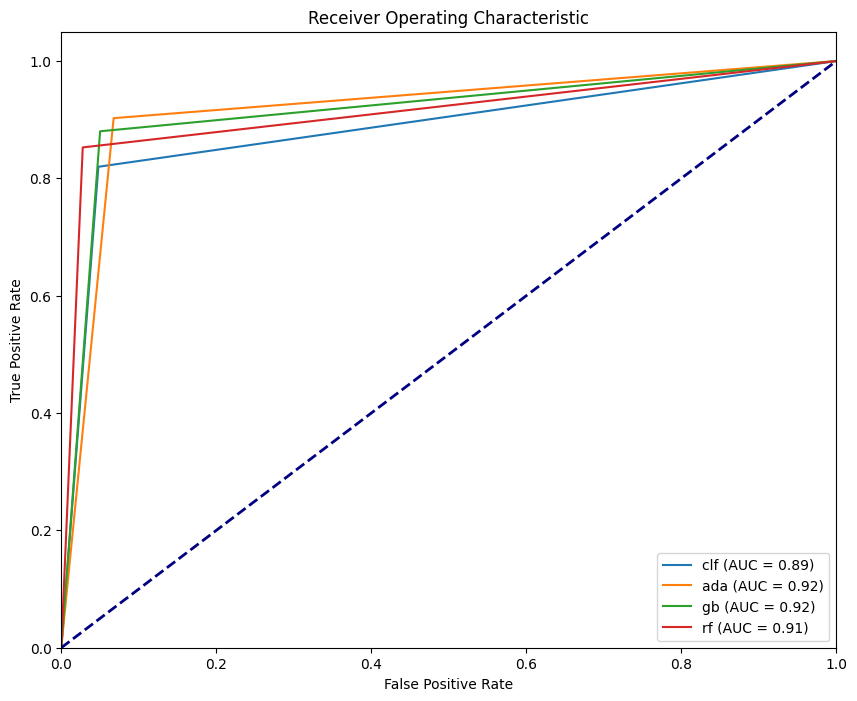

In [40]:
plt.figure(figsize=(10, 8))

for i, model in enumerate(models):
    fpr, tpr, _ = roc_curve(smaller_Y_test, predictions[i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{model} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

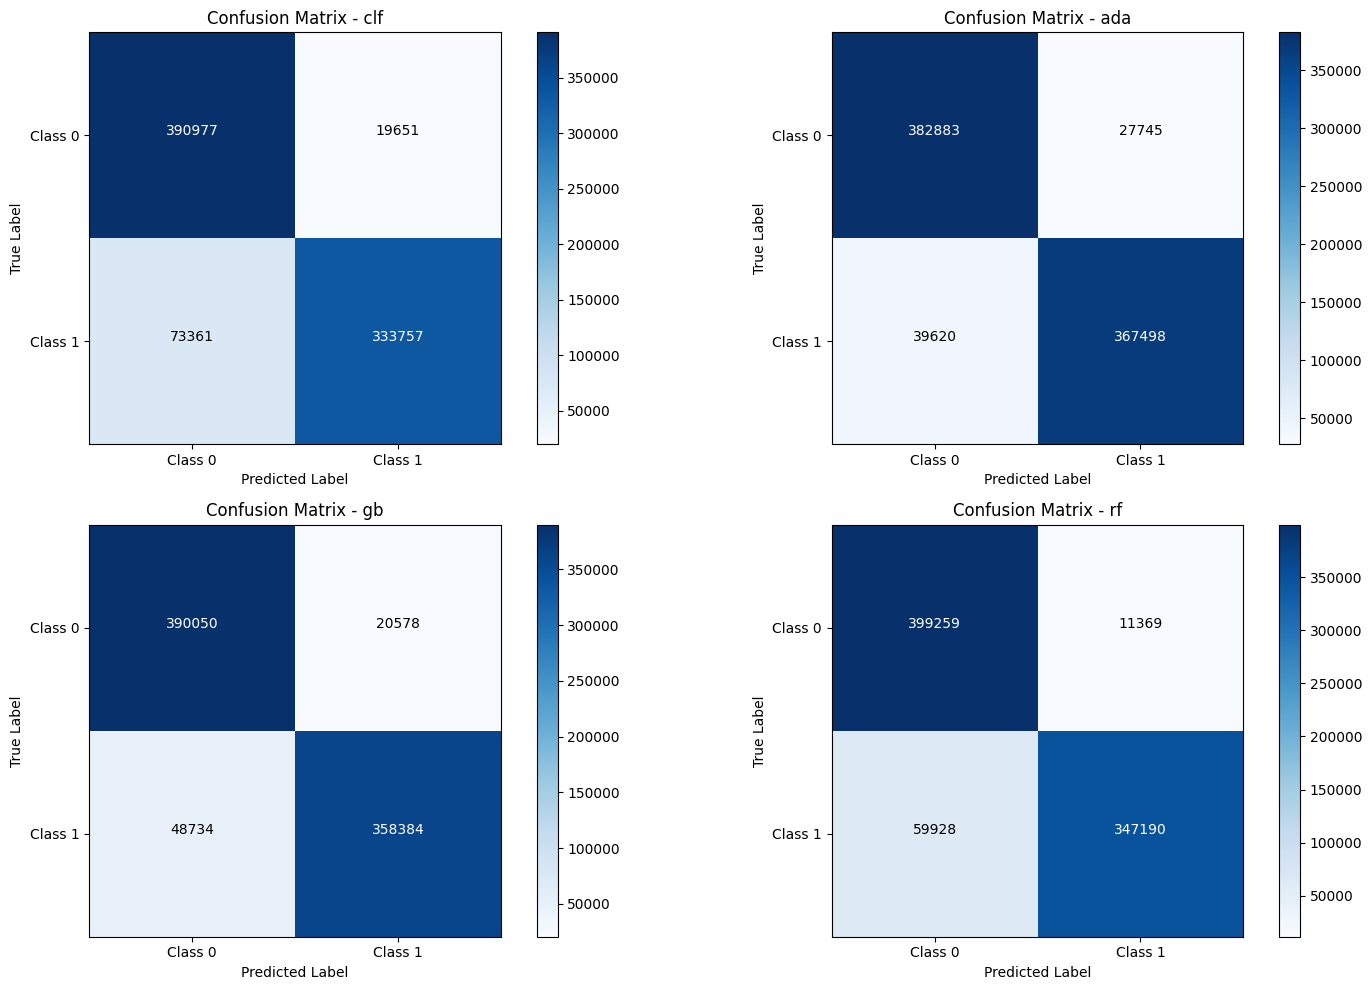

In [41]:
plt.figure(figsize=(15, 10))

for i, model in enumerate(models):
    plt.subplot(2, 2, i + 1)
    cm = confusion_matrix(smaller_Y_test, predictions[i])
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(f"Confusion Matrix - {model}")
    plt.colorbar()
    tick_marks = np.arange(2)
    plt.xticks(tick_marks, ["Class 0", "Class 1"])
    plt.yticks(tick_marks, ["Class 0", "Class 1"])
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")

    for i in range(2):
        for j in range(2):
            plt.text(j, i, str(cm[i, j]), horizontalalignment="center", color="white" if cm[i, j] > cm.max() / 2 else "black")

plt.tight_layout()
plt.show()

In [42]:
from tabulate import tabulate

# Assuming you already have the average metrics calculated and stored in lists like this:
models = ['clf', 'ada', 'gb', 'rf']
avg_accuracies = [avg_accuracy_clf, avg_accuracy_ada, avg_accuracy_gb, avg_accuracy_rf]
avg_precisions = [avg_precision_clf, avg_precision_ada, avg_precision_gb, avg_precision_rf]
avg_recalls = [avg_recall_clf, avg_recall_ada, avg_recall_gb, avg_recall_rf]

# Prepare the data for the table
table_data = []
for model, acc, prec, rec in zip(models, avg_accuracies, avg_precisions, avg_recalls):
    table_data.append([model, acc, prec, rec])

# Define headers for the table
headers = ["Model", "Average Accuracy", "Average Precision", "Average Recall"]

# Print the table
table = tabulate(table_data, headers, tablefmt="grid")
print(table)


+---------+--------------------+---------------------+------------------+
| Model   |   Average Accuracy |   Average Precision |   Average Recall |
+=========+====================+=====================+==================+
| clf     |           0.88654  |            0.944961 |         0.819834 |
+---------+--------------------+---------------------+------------------+
| ada     |           0.917553 |            0.929605 |         0.902742 |
+---------+--------------------+---------------------+------------------+
| gb      |           0.915425 |            0.945806 |         0.880562 |
+---------+--------------------+---------------------+------------------+
| rf      |           0.913176 |            0.968841 |         0.853023 |
+---------+--------------------+---------------------+------------------+
